In [5]:
%pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [23]:
import warnings
warnings.filterwarnings('ignore')

# Import data manipulation libraries
import pandas as pd
import numpy as np
from pprint import pprint
from collections import OrderedDict
from numpy.linalg import multi_dot
from scipy import stats
from tabulate import tabulate
import yfinance as yf

# Import plotly express
import plotly.express as px
px.defaults.width, px.defaults.height = 1000, 600

# Set precision
pd.set_option('display.precision', 4)

In [24]:
from sqlalchemy import create_engine, text
engine = create_engine('sqlite:///India')

In [25]:
nifty50 = pd.read_html("https://en.wikipedia.org/wiki/NIFTY_50")[2].Symbol.to_list

In [26]:
data = [yf.download(symbol+'.NS', period='1y', progress=False).reset_index() for symbol in nifty50()]

In [27]:
for frame,symbol in zip(data, nifty50()):
    frame.to_sql(symbol, engine, if_exists='replace', index=False)

In [28]:
assets = sorted(['ICICIBANK', 'ITC', 'RELIANCE', 'TCS', 'ASIANPAINT'])
print(assets)

['ASIANPAINT', 'ICICIBANK', 'ITC', 'RELIANCE', 'TCS']


In [29]:
df = pd.DataFrame()
for asset in assets:
    query = f'SELECT Date, Close FROM  {asset}'
    with engine.connect() as connection:
        df1 = pd.read_sql_query(text(query), connection, index_col='Date')
        df1.columns = [asset]
    df = pd.concat([df, df1], axis=1)

# View dataframe
df

,ASIANPAINT,ICICIBANK,ITC,RELIANCE,TCS
Date,,,,,
2023-07-31 00:00:00.000000,3377.3501,998.30,465.70,2549.2500,3421.4500
2023-08-01 00:00:00.000000,3342.9500,994.55,464.80,2513.2000,3452.0500
2023-08-02 00:00:00.000000,3362.8999,986.95,460.10,2486.3501,3440.6499
2023-08-03 00:00:00.000000,3336.3501,965.00,456.05,2475.8999,3399.9500
2023-08-04 00:00:00.000000,3339.6499,970.50,454.95,2509.5500,3443.5500
...,...,...,...,...,...
2024-07-25 00:00:00.000000,2901.3999,1197.90,489.95,2984.8000,4322.5000
2024-07-26 00:00:00.000000,2950.1499,1207.20,502.20,3018.0500,4387.8501
2024-07-29 00:00:00.000000,2954.7000,1212.70,496.05,3040.2000,4381.1001


In [30]:
returns = df.pct_change().dropna()
returns.head()

,ASIANPAINT,ICICIBANK,ITC,RELIANCE,TCS
Date,,,,,
2023-08-01 00:00:00.000000,-0.0102,-0.0038,-0.0019,-0.0141,0.0089
2023-08-02 00:00:00.000000,0.0060,-0.0076,-0.0101,-0.0107,-0.0033
2023-08-03 00:00:00.000000,-0.0079,-0.0222,-0.0088,-0.0042,-0.0118
2023-08-04 00:00:00.000000,0.0010,0.0057,-0.0024,0.0136,0.0128
2023-08-07 00:00:00.000000,0.0010,0.0053,-0.0001,0.0057,0.0118


In [31]:
#for ICICI
stockreturns = returns['ICICIBANK']

mean = np.mean(stockreturns)
stdev = np.std(stockreturns)

#VaR at different confidence level
VaR_90 = stats.norm.ppf(1-0.9, mean,stdev)
VaR_95 = stats.norm.ppf(1-0.95, mean,stdev)
VaR_99 = stats.norm.ppf(1-0.99, mean,stdev)

#results in a tabular format
table = [['90%', VaR_90], ['95%', VaR_95], ['99%', VaR_99]]
header = ['Confidence Level', 'Value at Risk']
print(tabulate(table, headers = header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0150004
95%                      -0.0195076
99%                      -0.0279622


## Hist sim method

In [32]:
hVaR_90 = returns['ICICIBANK'].quantile(0.1)
hVaR_95 = returns['ICICIBANK'].quantile(0.05)
hVaR_99 = returns['ICICIBANK'].quantile(0.01)

#Table
table = [['90%', hVaR_90], ['95%', hVaR_95], ['99%', hVaR_99]]
header = ['Confidence Level', 'Value at Risk']
print(tabulate(table, headers = header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0111492
95%                      -0.0164509
99%                      -0.0286656


## Monte carlo VaR

In [33]:
np.random.seed(42)

n_sims = 5000

sim_returns = np.random.normal(mean, stdev, n_sims)

MCVaR_90 = np.percentile(sim_returns, 10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns, 1)

#Table
table = [['90%', MCVaR_90], ['95%', MCVaR_95], ['99%', MCVaR_99]]
header = ['Confidence Level', 'Value at Risk']
print(tabulate(table, headers = header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0148497
95%                      -0.0191203
99%                      -0.0284172


### Normality Test
In the Parametric VaR, we assumed that the returns are normally distributed. However, in the real world, we know that stock / portfolio returns do not necessarily follow a normal distribution. Let's perform a quick check to determine the normality of the underlying returns and see whether we need to modify our approach in deriving the VaR numbers.

#### Shapiro
The Shapiro-Wilk test is a test of normality and is used to determine whether or not a sample comes from a normal distribution.

In [34]:
stats.shapiro(stockreturns)

ShapiroResult(statistic=0.920652511041834, pvalue=3.947249492542754e-10)

The p-value using shapiro is quite low, hence we reject the null hypothesis

#### Anderson-Darling
Alternatively, we can perform an Anderson-Darling Test. It is a goodness of fit test that measures how well the data fit a specified distribution. This test is most commonly used to determine whether or not the data follow a normal distribution.

In [35]:
stats.anderson(stockreturns)

AndersonResult(statistic=3.172197465469509, critical_values=array([0.567, 0.646, 0.775, 0.904, 1.075]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0008985151767720251, scale=0.012431524768644779)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Based on the above result, the null hypothesis is rejected since the test statistic value is much higher than the critical value of 1.09 even at 1% significance level.

In [36]:
px.histogram(returns,
            histnorm = 'probability density',
            title = 'Histogram of returns',
            barmode = 'relative')

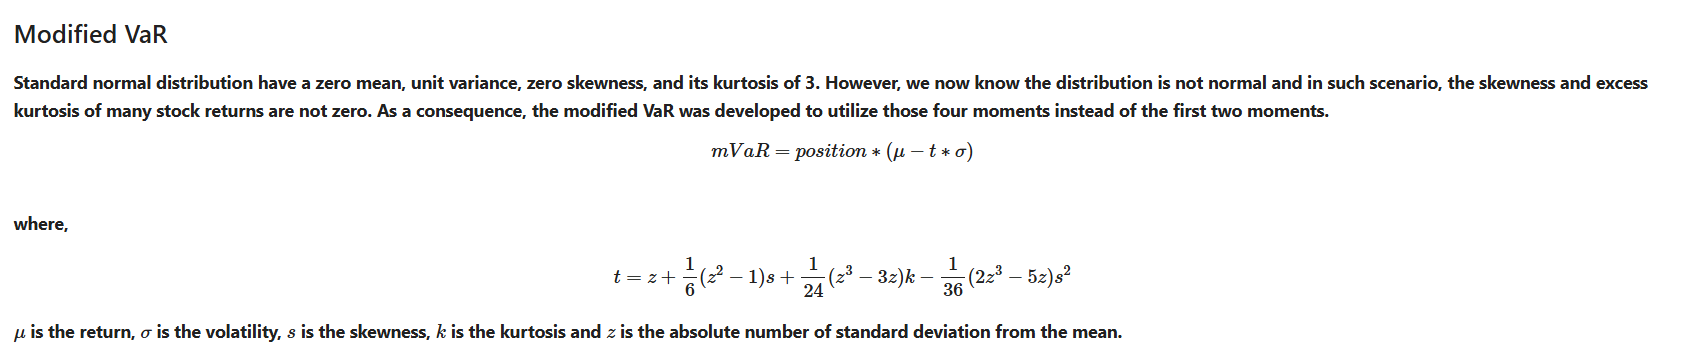

In [37]:
dist = OrderedDict({
    'Mean' : np.mean(returns['ICICIBANK']),
    'stdev': np.std(returns['ICICIBANK']),
    'Skew' : stats.skew(returns['ICICIBANK']),
    'Kurtosis' : stats.kurtosis(returns['ICICIBANK'])
})

pprint(dist)

OrderedDict([('Mean', 0.0008985151767720251),
             ('stdev', 0.012406024178164141),
             ('Skew', -0.4833405980182219),
             ('Kurtosis', 6.940640814148896)])


In [38]:
z=abs(stats.norm.ppf(0.01))
s = stats.skew(stockreturns)
k = stats.kurtosis(stockreturns)

t = z + (1/6)*(z**2-1)*s + (1/24)*(z**3-3*z)*k -1/36*(2*z**3-5*z)*s**2

mVaR_99 = (mean-t*stdev)
mVaR_99

-0.04259275346724887

## Scaling of VaR

We can scale 1-Day VaR to T-day VaR by multiplying square root of time.

$$VaR = position * (\mu - z*\sigma) * \sqrt{T}$$

Where $T$ is the horizon of the forcast period.

In [41]:
# VaR scaling
forecast_days = 5

scaled_VaR_90 = VaR_90 * np.sqrt(forecast_days)
scaled_VaR_95 = VaR_95 * np.sqrt(forecast_days)
scaled_VaR_99 = VaR_99 * np.sqrt(forecast_days)

# Table
table = [[f'90% {forecast_days} day VaR', scaled_VaR_90], [f'95% {forecast_days} day VaR', scaled_VaR_95], [f'99% {forecast_days} day VaR', scaled_VaR_99]]
header = ['Confidence Level', 'Value at Risk']
print(tabulate(table, headers = header))


Confidence Level      Value at Risk
------------------  ---------------
90% 5 day VaR            -0.033542
95% 5 day VaR            -0.0436203
99% 5 day VaR            -0.0625254


In [42]:
sVaR = pd.DataFrame([-100*VaR_99*np.sqrt(x) for x in range(100)], columns=['ScaledVaR'])
px.scatter(sVaR, sVaR.index,'ScaledVaR',title='Scaled VaR', labels={'index':'Horizon'})

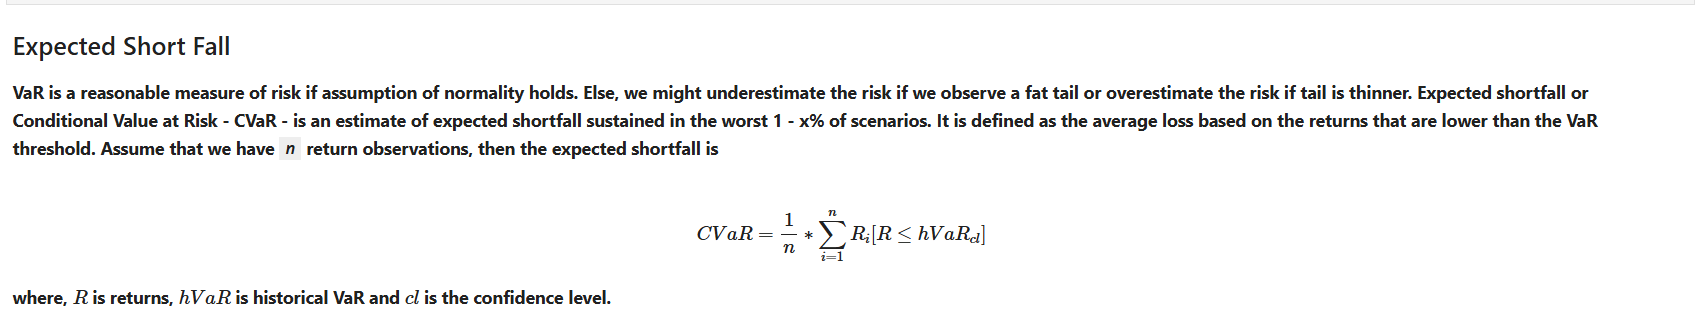

In [47]:
CVaR_90 = returns['ICICIBANK'][returns['ICICIBANK']<= hVaR_90].mean()
CVaR_95 = returns['ICICIBANK'][returns['ICICIBANK']<= hVaR_95].mean()
CVaR_99 = returns['ICICIBANK'][returns['ICICIBANK']<= hVaR_99].mean()

# Table
table = [['90% ', CVaR_90], ['95%', CVaR_95], ['99%', CVaR_99]]
header = ['Confidence Level', 'Value at Risk']
print(tabulate(table, headers = header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0202586
95%                      -0.0268734
99%                      -0.0458273


### Portfolio VaR

If we know the returns and volatalities of all the assets in the portfolio, we can arrive at portfolio level VaR.

In [51]:
# Weights assigned to each asset, wrights are taken from minimum variance portfolio consisting of indian stocks
wts = np.array([2.553e-01,  4.434e-02,  2.944e-01,  8.664e-02,  3.193e-01])


#portfolio mean return and volatility
port_mean = wts.T @ returns.mean()
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
pVaR = stats.norm.ppf(1-0.9, port_mean, port_stdev)

print(f"Mean: {port_mean}, Stdev: {port_stdev}, pVaR: {pVaR}")

Mean: 0.0004702044198066753, Stdev: 0.007830226026949685, pVaR: -0.00956463400359877
